Doing the vertical integral of v*MSE first and then computed its divergent component

In [1]:
import numpy as np
import xarray as xr

def make_constant_ps_like(sample_da, value_hPa=1000.0):
    """
    Create a constant surface-pressure DataArray on the (lat, lon) grid of 'sample_da'.

    Parameters
    ----------
    sample_da : xr.DataArray or xr.Dataset
        Any object that contains 'lat' and 'lon' coordinates on the target grid.
        Typically use u.isel(plev=0) or v.isel(plev=0) or any 2-D field with (lat, lon).
    value_hPa : float
        Constant surface pressure in hPa (default: 1000 hPa).

    Returns
    -------
    ps : xr.DataArray
        Surface pressure (Pa) with dims ('lat', 'lon') on the same grid as sample_da.
    """
    # get coords from the sample
    lat = sample_da['lat']
    lon = sample_da['lon']

    ps_values = np.full((lat.size, lon.size), value_hPa * 100.0, dtype=np.float32)  # convert hPa -> Pa
    ps = xr.DataArray(
        ps_values,
        coords={'lat': lat, 'lon': lon},
        dims=('lat', 'lon'),
        name='ps'
    )
    ps.attrs.update({'units': 'Pa', 'long_name': f'Constant surface pressure ({value_hPa:.0f} hPa)'})
    return ps

In [2]:
def barotropic_mass_correction(u, v, plev, ps):
    """
    Barotropic mass correction following Trenberth (1991)
    and Wei & Bordoni (2020) Supplementary Text S1.

    Parameters
    ----------
    u, v : xr.DataArray
        Zonal and meridional winds (plev, lat, lon)
    plev : xr.DataArray
        Pressure levels in Pa (plev,)
    ps : xr.DataArray
        Surface pressure (lat, lon)

    Returns
    -------
    u_corr, v_corr : xr.DataArray
        Barotropically corrected winds
    """

    g=9.81
    
    # #########Earlier: before Claude################
    # # -----------------------------
    # # 1. Compute layer thickness dp
    # # -----------------------------
    # dp = plev.diff("plev")
    # dp = xr.concat([dp.isel(plev=0), dp], dim="plev")
    # dp = dp.assign_coords(plev=plev)
    # print("printing dp from u_corr", dp)

    # # -------------------------------------------
    # # 2. Vertically integrated mass flux M = ∫ v dp
    # # -------------------------------------------
    # Mx = (u * dp).sum("plev")  # zonal mass flux
    # My = (v * dp).sum("plev")  # meridional mass flux

    # Mx = Mx.fillna(0.0)
    # My = My.fillna(0.0)

    ##########From Claude
    # # -----------------------------
    # # 1. Compute layer thickness dp
    # # -----------------------------
    # # Method 1: Use absolute value and proper edge handling
    # dp = abs(plev.diff("plev"))
    
    # # For the boundaries, duplicate the adjacent layer thickness
    # # Top boundary: duplicate first difference
    # # Bottom boundary: duplicate last difference
    # dp_top = dp.isel(plev=0)
    # dp = xr.concat([dp_top, dp], dim="plev")
    
    # # Reassign coordinates to match original plev
    # dp = dp.assign_coords(plev=plev)
    # print("printing dp from u_corr", dp)

    #######Mid-point approach from Claude#########
    # -----------------------------
    # 1. Compute layer thickness dp for each level
    # -----------------------------
    # For interior points: use centered difference
    # For boundaries: use one-sided difference
    
    n_lev = len(plev)
    dp_vals = np.zeros(n_lev)
    
    # Top level (index 0): use distance to next level
    dp_vals[0] = abs(plev.values[1] - plev.values[0])
    
    # Interior levels: use centered difference (distance to neighbors / 2 on each side)
    for i in range(1, n_lev - 1):
        dp_vals[i] = abs(plev.values[i+1] - plev.values[i-1]) / 2.0
    
    # Bottom level: use distance to previous level
    dp_vals[-1] = abs(plev.values[-1] - plev.values[-2])
    
    # Create DataArray
    dp = xr.DataArray(dp_vals, coords={"plev": plev}, dims=["plev"])

    print("printing dp before u_corr", dp)
    print("printing ps before u_corr", ps)
    

    
    # -------------------------------------------
    # 2. Vertically integrated mass flux M = (1/g) ∫ v dp
    # -------------------------------------------
    Mx = (u * dp).sum("plev") / g # zonal mass flux
    My = (v * dp).sum("plev") / g # meridional mass flux
    Mx = Mx.fillna(0.0)
    My = My.fillna(0.0)


    # ------------------------------------------------------------
    # 3. Extract DIVERGENT (irrotational) component of M using:
    #       M_div = ∇χ = vw.irrotationalcomponent()
    # ------------------------------------------------------------
    # vwM = VectorWind(Mx, My)
    # Mx_div, My_div = vwM.irrotationalcomponent()
    Mx_div_list = []
    My_div_list = []
    
    for t in range(Mx.time.size):
        vwM = VectorWind(
            Mx.isel(time=t),
            My.isel(time=t)
        )
        
        Mx_d, My_d = vwM.irrotationalcomponent()
        
        Mx_div_list.append(
            xr.DataArray(
                Mx_d,
                coords={"lat": Mx.lat, "lon": Mx.lon},
                dims=("lat", "lon")
            )
        )
        
        My_div_list.append(
            xr.DataArray(
                My_d,
                coords={"lat": My.lat, "lon": My.lon},
                dims=("lat", "lon")
            )
        )
    
    Mx_div = xr.concat(Mx_div_list, dim="time")
    My_div = xr.concat(My_div_list, dim="time")
    
    Mx_div = Mx_div.assign_coords(time=Mx.time)
    My_div = My_div.assign_coords(time=My.time)

    # THIS IS THE KEY FIX:
    p_t = plev.min()  # top level pressure
    atmospheric_mass = (ps - p_t) / g  # This is in kg/m²
    print("atmospheric_mass",atmospheric_mass)
    
    # ------------------------------------------------------------
    # 4. Barotropic correction: M_bt = - M_div / p_s
    #
    # Because we want:
    #    M + p_s * u_bt = M_nondivergent
    # => p_s * u_bt = - M_div
    # ------------------------------------------------------------
    u_bt = -Mx_div / atmospheric_mass ;#ps
    v_bt = -My_div / atmospheric_mass ;#ps

    # ------------------------------------------------------------
    # 5. Expand barotropic correction to all vertical levels
    # ------------------------------------------------------------
    u_bt_3D = u_bt.expand_dims({"plev": u.plev}, axis=0)
    v_bt_3D = v_bt.expand_dims({"plev": v.plev}, axis=0)

    u_corr = u + u_bt_3D
    v_corr = v + v_bt_3D

    return u_corr, v_corr


In [3]:
def windspharm_time_loop(u, v, method="divergentcomponent"):

    out1_list = []
    out2_list = []

    for t in range(u.time.size):
        vw = VectorWind(u.isel(time=t), v.isel(time=t))
        out1, out2 = getattr(vw, method)()

        out1_list.append(xr.DataArray(out1, coords={"lat": u.lat, "lon": u.lon}, dims=("lat","lon")))
        out2_list.append(xr.DataArray(out2, coords={"lat": u.lat, "lon": u.lon}, dims=("lat","lon")))

    out1 = xr.concat(out1_list, dim="time").assign_coords(time=u.time)
    out2 = xr.concat(out2_list, dim="time").assign_coords(time=u.time)

    return out1, out2

The aim is to read plot EFE

1) Adam, O., T. Bischoff, and T. Schneider, 2016: Seasonal and Interannual Variations of the Energy Flux Equator and ITCZ. Part I: Zonally Averaged ITCZ Position. J. Climate, 29, 3219–3230, https://doi.org/10.1175/JCLI-D-15-0512.1.
2) EFPM : NOT USING NOW. keeping the reference here: Boos, W., Korty, R. Regional energy budget control of the intertropical convergence zone and application to mid-Holocene rainfall. Nature Geosci 9, 892–897 (2016). https://doi.org/10.1038/ngeo2833


In [4]:
import numpy as np
import xarray as xr
# our local module:
import itcz

import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
import xarray as xr
from pathlib import Path
import myfunctions as mf

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# from xarrayutils import divergence_spherical, helmholtz_decomposition_spectral  # placeholder functions

In [7]:
ds_t = xr.open_mfdataset(
    "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/ta/gn/latest/*.nc",
    combine="by_coords", parallel=True, decode_times=True, use_cftime=True)

# print("T in units of K",ds_t)

ds_q = xr.open_mfdataset(
    "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/hus/gn/latest/*.nc",
    combine="by_coords", parallel=True, decode_times=True, use_cftime=True)

# print("q in units of 1",ds_q)

ds_z = xr.open_mfdataset(
    "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/zg/gn/latest/*.nc",
    combine="by_coords", parallel=True, decode_times=True, use_cftime=True)

# print("z in unit of meter",ds_z)

ds_u = xr.open_mfdataset(
    "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/ua/gn/latest/*.nc",
    combine="by_coords", parallel=True, decode_times=True, use_cftime=True)

# print("u in unit of meter/sec",ds_u)

ds_v = xr.open_mfdataset(
    "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/va/gn/latest/*.nc",
    combine="by_coords", parallel=True, decode_times=True, use_cftime=True)

# print("v in unit of meter/sec",ds_v)

In [8]:
# ----------------------------
# Helper: convert integer years to cftime slice
# ----------------------------
def year_slice_to_cftime(da, start_year, end_year):
    """Convert integer years to cftime slice for a DataArray"""
    start = cftime.Datetime360Day(start_year, 1, 1)
    end   = cftime.Datetime360Day(end_year, 12, 30)
    return slice(start, end)

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from windspharm.standard import VectorWind
import cftime
import mse_divergence

# ----------------------------
# CONSTANTS
# ----------------------------
Cp = 1004.0        # J kg-1 K-1
Lv = 2.5e6         # J kg-1
g  = 9.81          # m s-2
R  = 6.371e6       # Earth radius (m)

# ----------------------------
# BLOCK 1: READING VARIABLES (lat,lon,lev,time)
# ----------------------------

start_year = 2071
end_year   = 2101 ;# These are not used at the moment since I am testing with historical run

ta_mean = ds_t.ta.sel(time=slice("2001-01-01", "2002-12"))
q_mean  = ds_q.hus.sel(time=slice("2001-01-01", "2002-12"))
z_mean  = ds_z.zg.sel(time=slice("2001-01-01", "2002-12"))
u_mean  = ds_u.ua.sel(time=slice("2001-01-01", "2002-12"))
v_mean  = ds_v.va.sel(time=slice("2001-01-01", "2002-12")) ;#.mean("time")


# ----------------------------
# BLOCK 2.1 : MOIST STATIC ENERGY (lat,lon,lev,time)
# ----------------------------
h = Cp * ta_mean + Lv * q_mean + g * z_mean
h_on_v = h.interp(lat=v_mean.lat, lon=v_mean.lon, plev=v_mean.plev, method="linear")


# ----------------------------
# BLOCK 2.2 : BAROTROPIC CORRECTION (lat,lon,lev,time)
# ----------------------------
# Fill NaNs
u_filled = u_mean.fillna(0.0)
v_filled = v_mean.fillna(0.0)

# Barotropic mass correction: sophisticated way
ps_const = make_constant_ps_like(u_filled.isel(plev=0), value_hPa=1000.0)
u_corr, v_corr = barotropic_mass_correction(u_filled, v_filled, plev=u_filled.plev, ps=ps_const) ;#use this function in this script


# ----------------------------
# BLOCK 3 : COMPUTE UH and VH (lat,lon,lev,time)
# ----------------------------
# Zonal wind * MSE
uh = u_corr * h_on_v

# Meridional wind * MSE
vh = v_corr * h_on_v

# Ensure monotonic plev and fill NaNs
uh_sorted = uh.sortby("plev").fillna(0.0)
vh_sorted = vh.sortby("plev").fillna(0.0)

plev_vals = np.array(vh_sorted.plev.values, dtype=float)
order = np.argsort(plev_vals)

uh_clean = uh_sorted.isel(plev=order).assign_coords(plev=plev_vals[order])
vh_clean = vh_sorted.isel(plev=order).assign_coords(plev=plev_vals[order])

##############################################
########### Vertical integration #############
##############################################

# uh_int = uh_clean.integrate("plev") / g
# vh_int = vh_clean.integrate("plev") / g

##############################################
########### Mid-point approach ###############
##############################################
# Get the pressure levels
plev = vh_clean.plev

# --------------------------------------------
# Compute layer thickness dp for each level (same as barotropic correction)
# --------------------------------------------
n_lev = len(plev)
dp_vals = np.zeros(n_lev)

# Top level (index 0): use distance to next level
dp_vals[0] = abs(plev.values[1] - plev.values[0])

# Interior levels: use centered difference
for i in range(1, n_lev - 1):
    dp_vals[i] = abs(plev.values[i+1] - plev.values[i-1]) / 2.0

# Bottom level: use distance to previous level
dp_vals[-1] = abs(plev.values[-1] - plev.values[-2])

# Create DataArray
dp = xr.DataArray(dp_vals, coords={"plev": plev}, dims=["plev"])
dp = dp.assign_coords(plev=plev)

# ----------------------------
# BLOCK 4 : COMPUTE INTEGRAL (lat,lon,time)
# ----------------------------
# Computing (1/g) ∫ v dp
uh_int = (uh_clean * dp / g).sum("plev")
vh_int = (vh_clean * dp / g).sum("plev")

# ----------------------------
# BLOCK 5 : GET h_DIV (lat,lon,time)
# ----------------------------
Flambda_div, Fphi_div = windspharm_time_loop(uh_int, vh_int)

Fphi_div.name = "Fphi_div"
Fphi_div.attrs["long_name"] = "divergent meridional MSE flux"
Fphi_div.attrs["units"] = "W m^-1"

printing dp before u_corr <xarray.DataArray (plev: 8)> Size: 64B
array([15000., 15000., 17500., 22500., 20000., 10000.,  4500.,  4000.])
Coordinates:
  * plev     (plev) float64 64B 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
printing ps before u_corr <xarray.DataArray 'ps' (lat: 145, lon: 192)> Size: 111kB
array([[100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       ...,
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.]],
      shape=(145, 192), dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Attributes:
    units:      Pa
    long_name:  Constant s

In [10]:
Fphi_div_mean = Fphi_div.mean("time").compute()

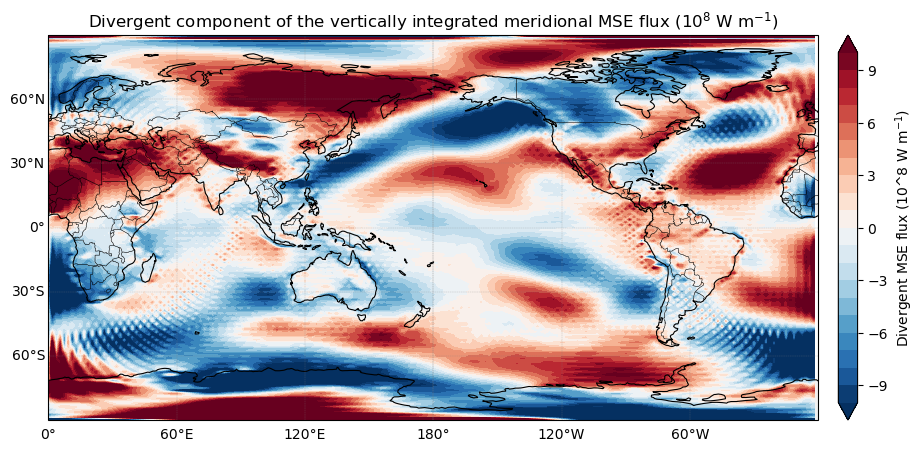

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

trop_lat = 90
F_div_tropics = (Fphi_div_mean.sel(lat=slice(-trop_lat, trop_lat))) / 1e8

fig = plt.figure(figsize=(13,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# Define symmetric levels around zero
vmax = 10
levels = np.linspace(-vmax, vmax, 21)

# Plot filled contours
pcm = ax.contourf(
    F_div_tropics["lon"],
    F_div_tropics["lat"],
    F_div_tropics,
    levels=levels,
    cmap="RdBu_r",
    extend="both",
    transform=ccrs.PlateCarree()
)

# # Add black contour at zero
# ax.contour(
#     F_div_tropics["lon"],
#     F_div_tropics["lat"],
#     F_div_tropics,
#     levels=[0],
#     colors="k",
#     linewidths=1,
#     transform=ccrs.PlateCarree()
# )

# Colorbar
cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Divergent MSE flux (10^8 W m$^{-1}$)")

# Cartopy features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

ax.set_title(r"Divergent component of the vertically integrated meridional MSE flux (10$^8$ W m$^{−1}$)")

plt.show()

Using daily data and follow these steps : \
    * Calculate barotropic mass correction and correct winds \
    * Calculate vh with the full v wind field \
    * Find divergent component of vh (at each level) \
    * Integrate \
    * I do a time averaging at the end